# Import Packages

In [1]:
%env MUJOCO_GL=egl

import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import nengo
import numpy as np
import PIL.Image

%matplotlib widget

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

from dm_control import composer, mjcf, mujoco
from dm_control.utils import inverse_kinematics as ik
from IPython.display import HTML
from multiprocessing import Process

env: MUJOCO_GL=egl


# Set Initial Pose and Simulation Parameters

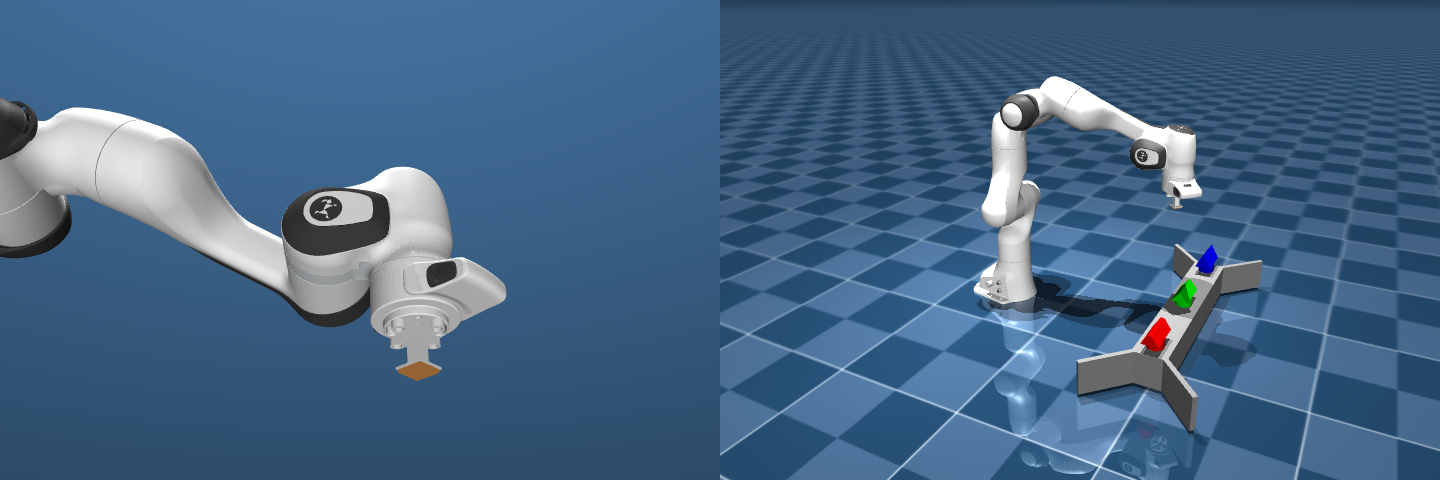

In [76]:
# Rendering parameters
dpi = 100
framerate = 24 # (Hz)
width, height = 720, 480
sensor_shape = (10, 10)


def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())


# IK solver parameters
_MAX_STEPS = 10
_TOL = 1e-7
site_name = 'attachment_site'
joint_names = ['joint{}'.format(i+1) for i in range(7)]

# Load scene
scene_xml = 'models/scene.xml'
physics = mujoco.Physics.from_xml_path(scene_xml)

# Set initial position
physics.reset()
physics.data.qpos[:7] = [np.pi, 0, np.pi, -2, 0, 2, 0]
physics.step()

# Simulation variables
qpos = physics.data.qpos[:7]
xpos = physics.named.data.site_xpos[site_name]
ctrl = np.zeros(physics.data.actuator_length.shape)
ctrl[:7] = qpos
duration = 3.0 # (seconds)
omega = np.pi/2 # Rotator angular velocity
time = 0.0

# Visualize initial pose
random_state = np.random.RandomState(1024)
pixels = []
cameras = random_state.choice(physics.model.ncam, physics.model.ncam, replace=False)
for camera_id in cameras:
    pixels.append(physics.render(camera_id=camera_id, width=width, height=height))
image = np.hstack((np.hstack(pixels[:N-1]), np.hstack(pixels[N-1:])))
PIL.Image.fromarray(image)

# Save Simulation to Video Frames

In [77]:
# Set initial joint positions
target_site = physics.data.site(name='reach_site1')
video = []
sensor_data = []

result = ik.qpos_from_site_pose(
        physics,
        site_name,
        target_pos=target_site.xpos,
        target_quat=[0, 0, 0, 1],
        tol=_TOL,
        joint_names=joint_names,
        max_steps=_MAX_STEPS,
)

t0 = physics.data.time
# Simulate, saving video frames
while physics.data.time - t0 < duration:
    # Inject controls and step the physics.
    t = physics.data.time
    ctrl[-3:] = omega*t
    ctrl[:7] = result.qpos[:7]
    physics.set_control(ctrl)
    physics.step()

    # Save video frames and sensor data
    if len(video) < physics.data.time * framerate:
        pixels = physics.render(camera_id='prospective', width=width, height=height)
        video.append(pixels.copy())
        
        data = physics.data.sensordata
        sensor_data.append(data.reshape(sensor_shape))

display_video(video, framerate)

In [46]:
site_names = ['reach_site{}'.format(i+1) for i in range(3)]
for site_name in site_names:
    site = physics.data.site(name=site_name)
    print(site_name)
    print(site.xpos + xpos, '\n')

reach_site1
[ 1.11913844 -0.02707654  0.29283759] 

reach_site2
[ 1.11913835 -0.27707654  0.29283767] 

reach_site3
[ 1.11913827 -0.52707654  0.29283775] 



In [ ]:
# Initialize animation
pixels = physics.render(camera_id='prospective', width=width, height=height)
video = [pixels]
data = physics.data.sensordata.reshape(shape)
sensor_data = [data]

fig, axs = plt.subplots(1, 2, figsize=(2*width / dpi, height / dpi), dpi=dpi)
axs[0].set_axis_off()
axs[0].set_aspect('equal')
im0 = axs[0].imshow(video[0])
axs[1].set_xlabel("neuron index")
axs[1].set_ylabel("neuron index")
axs[1].set_title("Touch Sensor")
axs[1].set_xticks(list(range(10)))
axs[1].set_yticks(list(range(10)))
im1 = axs[1].imshow(sensor_data[0])
    
    
def update(data):
    im0.set_data(data[0])
    im1.set_data(data[1])
    return [im0, im1]


def data_gen():
    while physics.data.time - t0 < duration:
        # Inject controls and step the physics.
        t = physics.data.time
        ctrl[-3:] = omega*t
    
        physics.set_control(ctrl)
        physics.step()
        pixels = physics.render(camera_id='prospective', width=width, height=height)
        data = physics.data.sensordata.reshape(shape)
    
        # Save video frames
        if len(video) < physics.data.time * framerate:
            video.append(pixels.copy())
            sensor_data.append(data)
        
        yield pixels, data

t0 = physics.data.time
anim = animation.FuncAnimation(fig=fig, func=update, frames=data_gen, interval=1000/framerate,  blit=True)
plt.tight_layout()
plt.show()

# Generate Strings to Define Sensor Sites and Touch Sensors to Inject into The XML file

In [94]:
n = 10
dx = 3e-3
offset = dx*(n-1)/2.0
for i in range(n*n):
    print('{}<site name="taxel_site{}" type="sphere" pos="{:.5f} -.002 {:.5f}" size=".001 .001 .001"/>'.format(' '*24, i+1, dx*(i//n)-offset, dx*(i%n)-offset))
for i in range(n*n):
    print('{}<touch name="taxel{}" site="taxel_site{}"/>'.format(' '*4, i+1, i+1))

                        <site name="taxel_site1" type="sphere" pos="-0.01350 -.002 -0.01350" size=".001 .001 .001"/>
                        <site name="taxel_site2" type="sphere" pos="-0.01350 -.002 -0.01050" size=".001 .001 .001"/>
                        <site name="taxel_site3" type="sphere" pos="-0.01350 -.002 -0.00750" size=".001 .001 .001"/>
                        <site name="taxel_site4" type="sphere" pos="-0.01350 -.002 -0.00450" size=".001 .001 .001"/>
                        <site name="taxel_site5" type="sphere" pos="-0.01350 -.002 -0.00150" size=".001 .001 .001"/>
                        <site name="taxel_site6" type="sphere" pos="-0.01350 -.002 0.00150" size=".001 .001 .001"/>
                        <site name="taxel_site7" type="sphere" pos="-0.01350 -.002 0.00450" size=".001 .001 .001"/>
                        <site name="taxel_site8" type="sphere" pos="-0.01350 -.002 0.00750" size=".001 .001 .001"/>
                        <site name="taxel_site9" type="sphere" pos=